In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

# Sprawdzenie spojnosci jpg i csv

In [16]:
import os
import pandas as pd

def validate_csv(csv_file, root_dir, output_csv):
    """
    Validate the CSV file by checking if the files exist in the dataset directory.
    Remove missing files and save a new CSV file.
    
    Args:
    - csv_file (str): Path to the input CSV file.
    - root_dir (str): Path to the dataset directory containing the images.
    - output_csv (str): Path to save the validated CSV file.
    """
    df = pd.read_csv(csv_file)
    
    valid_rows = []
    
    for idx, row in df.iterrows():

        img_path = os.path.join(root_dir, row[0])
        
        # Check if the file exists
        if os.path.exists(img_path):
            valid_rows.append(row)  # Keep valid rows
        else:
            print(f"File not found, skipping: {img_path}")
    

    valid_df = pd.DataFrame(valid_rows, columns=df.columns)
    

    valid_df.to_csv(output_csv, index=False)
    print(f"Validated CSV saved to {output_csv}")


csv_file = "wclasses.csv"   # Path to your original CSV file
root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"    # Path to your dataset directory
output_csv = 'validated_csv.csv'        # Path to save the new CSV file

validate_csv(csv_file, root_dir, output_csv)


C:\Users\Adas\AppData\Local\Temp\ipykernel_21044\674298775.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(root_dir, row[0])


File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_mending-the-sail-1896.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-the-village(2).jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-a-room-1981.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_boat-in-albufera-1908.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_raimundo-de-madrazo-in-his-paris-garden-1906.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Romanticism/pierre-

In [38]:
import pandas as pd
import numpy as np

def split_csv(input_csv, train_csv, test_csv, train_ratio=0.99, random_seed=42):
    """
    Split a CSV file into training and testing datasets.

    Args:
    - input_csv (str): Path to the input CSV file.
    - train_csv (str): Path to save the training CSV file.
    - test_csv (str): Path to save the testing CSV file.
    - train_ratio (float): Ratio of data to be used for training (default is 0.99).
    - random_seed (int): Seed for random number generator to ensure reproducibility.
    """
    # Load the validated CSV file
    df = pd.read_csv(input_csv)

    # Shuffle the data with a fixed random seed
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Calculate the split index
    split_idx = int(len(df_shuffled) * train_ratio)

    # Split into train and test datasets
    train_df = df_shuffled[:split_idx]
    test_df = df_shuffled[split_idx:]

    # Save the split datasets to CSV files
    train_df.to_csv(train_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    print(f"Training data saved to {train_csv} ({len(train_df)} samples)")
    print(f"Testing data saved to {test_csv} ({len(test_df)} samples)")

# Paths to the output files
input_csv = 'validated_csv.csv'  # Path to the validated CSV file
train_csv = 'validate_csv_train.csv'  # Path to save the training CSV file
test_csv = 'validate_csv_test.csv'    # Path to save the testing CSV file

# Call the function to split the CSV
split_csv(input_csv, train_csv, test_csv)

Training data saved to validate_csv_train.csv (79868 samples)
Testing data saved to validate_csv_test.csv (807 samples)


In [5]:
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx,1]

        if self.transform:
            image = self.transform(image)

        return image, label
    


In [65]:
#root_dir = r"C:\Users\Michal Miszczobrocki\.kaggle\wikiart"
#csv_file = r"C:\Users\Michal Miszczobrocki\.kaggle\wikiart\wclasses.csv"
root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
csv_file = "validated_csv.csv"

dataset = WikiArtDataset(csv_file, root_dir)

In [66]:
def show_image_from_dataset(dataset, idx):
    img, _ = dataset[idx]

    # If an image is a tensor -> convert to numpy
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0) 

        plt.imshow(img.numpy())
        plt.axis('off')  
        plt.show()
    
    # If an image is of type PIL.Image.Image
    elif isinstance(img, Image.Image):
        plt.imshow(img)
        plt.axis('off')  
        plt.show()

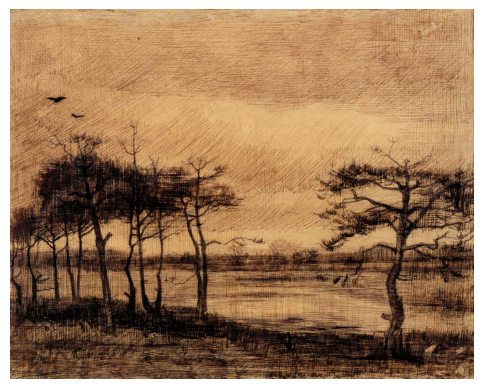

In [67]:
show_image_from_dataset(dataset,idx=0)

In [17]:
class RandomMask:
    def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
        self.mask_max_size = max_size_fraction
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice

    def calculate_polygon_area(self, vertices):
        """
        Calculate the area of a polygon using the shoelace formula.
        """
        n = len(vertices)
        area = 0
        for i in range(n):
            x1, y1 = vertices[i]
            x2, y2 = vertices[(i + 1) % n]  # Wrap to the first vertex
            area += x1 * y2 - y1 * x2
        return abs(area) / 2

    def validate_polygon_area(self, img, polygon_area):
        img_width, img_height = img.size
        image_resolution = img_width * img_height
        
        if polygon_area / image_resolution <= self.mask_max_size:
            return True
        else:
            return False

    def __call__(self, image):
        # Randomly decide between square mask and random mask
        if self.mask_choice is None:
            self.mask_choice = random.choice(["square", "random_square", "random_polygon", "random_noise"])
        
        # Mask size, dimensions 
        im_width, im_height = image.size
        max_mask_size = int((im_width * im_height) * self.mask_max_size)
        square_mask_size = int(max_mask_size ** 0.5)

        # Create a binary damage mask to track the damaged regions
        damage_mask = np.zeros((im_height, im_width), dtype=np.uint8)

        if self.mask_choice == "square":
            # Random mask coordinates
            x = random.randint(0, im_width - square_mask_size)
            y = random.randint(0, im_height - square_mask_size)

            # Create and apply the square mask
            region = image.crop((x, y, x + square_mask_size, y + square_mask_size))
            image.paste((255, 255, 255), (x, y, x + square_mask_size, y + square_mask_size))
            damage_mask[y:y + square_mask_size, x:x + square_mask_size] = 1

        elif self.mask_choice == "random_square":
            small_mask_size = 100
            iterations = max_mask_size // (small_mask_size * small_mask_size) 

            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)

                # Apply the random mask directly to the image
                image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
                damage_mask[y:y + small_mask_size, x:x + small_mask_size] = 1

        elif self.mask_choice == "random_polygon":
            valid_polygon_area = False
            while not valid_polygon_area:
                temp_img = image.copy()
                draw = ImageDraw.Draw(temp_img)

                # Number of vertices
                num_vertices = random.randint(3, self.max_vertices)  
                vertices = []

                for _ in range(num_vertices):
                    x = random.randint(0, im_width - 10)  
                    y = random.randint(0, im_height - 10) 
                    vertices.append((x, y))

                polygon_area = self.calculate_polygon_area(vertices)
                valid_polygon_area = self.validate_polygon_area(image, polygon_area)
            
            draw = ImageDraw.Draw(image)
            draw.polygon(vertices, fill=(255, 255, 255))
            # Create the mask for the polygon
            mask_image = Image.new("L", (im_width, im_height), 0)
            mask_draw = ImageDraw.Draw(mask_image)
            mask_draw.polygon(vertices, fill=1)
            damage_mask = np.array(mask_image) | damage_mask

        elif self.mask_choice == "random_noise":
            # Create random noise
            rng = np.random.default_rng()  # Initialize random number generator
            noise = rng.integers(0, 255, (image.height, image.width), np.uint8, True)  # Generate noise

            # Blur the noise image to control the size
            blur = cv2.GaussianBlur(noise, (0, 0), sigmaX=15, sigmaY=15, borderType=cv2.BORDER_DEFAULT)

            # Stretch the blurred image to full dynamic range
            stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255)).astype(np.uint8)

            # Threshold stretched image to control the size
            thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]

            # Apply morphology open and close to smooth out shapes
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
            result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
            total_area = 0
            max_threshold = int((im_width * im_height) * self.mask_max_size)  # Set your desired maximum area threshold here
            valid_blobs = []  # To store valid blobs

            blob_indices = list(range(1, num_labels))
            # Shuffle the blob indices randomly
            random.shuffle(blob_indices)

            for i in blob_indices:  # Start from 1 to skip the background
                area = stats[i, cv2.CC_STAT_AREA]
                if total_area + area <= max_threshold:
                    total_area += area
                    valid_blobs.append(i)  # Keep track of valid blobs

            # Create a mask from valid blobs
            valid_mask = np.zeros_like(result)
            for blob in valid_blobs:
                valid_mask[labels == blob] = 255  # Assign white to valid blobs

            # Update the damage mask
            damage_mask[valid_mask > 0] = 1

            # Create a PIL Image from the valid mask
            final_mask = Image.fromarray(valid_mask).convert("L")

            # Apply the mask to the original image (white for masked regions)
            white_mask = Image.new("RGB", image.size, (255, 255, 255))  # White mask
            image = Image.composite(white_mask, image, final_mask)

        # Add the binary damage mask as the fourth channel
        rgb_array = np.array(image)
        rgba_array = np.dstack((rgb_array, damage_mask * 255))
        return Image.fromarray(rgba_array, mode="RGBA")

In [23]:
import os
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class MaskedImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations (image path and labels).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Transform to apply to the original image.
            mask_transform (callable, optional): Mask transformation for damaging the image.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load the image and label
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]  # Assuming labels are in the second column
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations to the original image
        original_image = self.transform(image) if self.transform else transforms.ToTensor()(image)
        
        damaged_image = None
        if self.mask_transform:
            # Apply the masking transform
            damaged_image = self.mask_transform(image.copy())
            
            # Separate RGBA channels
            damaged_image = np.array(damaged_image)
            rgba_image = Image.fromarray(damaged_image[:, :, :3])  # RGB image
            damage_mask = Image.fromarray(damaged_image[:, :, 3])  # Alpha channel
            
            # Apply the same transformations to both the RGB image and the damage mask
            if self.transform:
                rgba_image = self.transform(rgba_image)
                damage_mask = self.transform(damage_mask)
            else:
                rgba_image = transforms.ToTensor()(rgba_image)
                damage_mask = transforms.ToTensor()(damage_mask)
            
            # Concatenate the damage mask as an additional channel
            damaged_image = torch.cat((rgba_image, damage_mask), dim=0)
        
        # Return all three: original_image, damaged_image, and label
        return original_image, damaged_image, label



In [26]:
def plot_damaged_image(dataset, index):
    """
    Plot an image with its mask applied (use only the RGB channels for display).
    
    Args:
        dataset (MaskedImageDataset): The dataset instance.
        index (int): Index of the image to plot.
    """
    # Unpack all three returned values
    original_image, damaged_image, label = dataset[index]
    
    # Convert tensor to numpy array and transpose to HWC format for plotting
    if isinstance(original_image, torch.Tensor):
        original_image = original_image.permute(1, 2, 0).numpy()
    if isinstance(damaged_image, torch.Tensor):
        damaged_rgb = damaged_image[:3].permute(1, 2, 0).numpy()  # Extract RGB channels
    else:
        damaged_rgb = damaged_image[:, :, :3]  # If damaged_image is a numpy array
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(damaged_rgb)
    axes[1].set_title("Damaged Image")
    axes[1].axis("off")
    
    plt.suptitle(f"Label: {label}")
    plt.show()


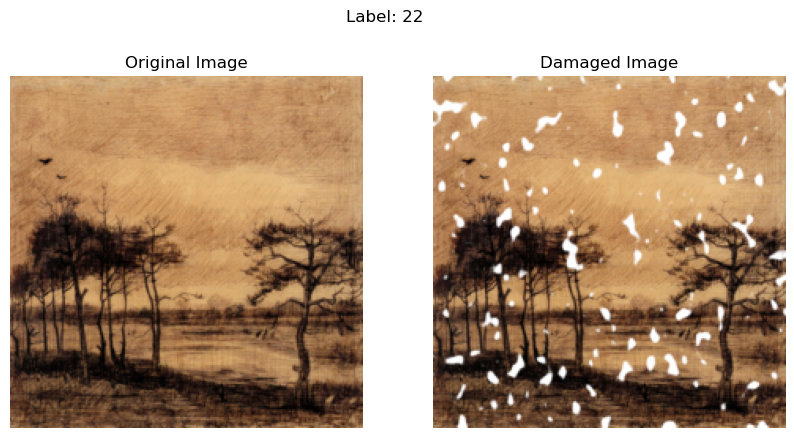

In [37]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
mask_transform = RandomMask(max_size_fraction=1/16, max_vertices=8, mask_choice="random_noise")


#csv_file = "validated_csv_easy_2.csv"
csv_file = "validated_csv.csv"
root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"

# Create the dataset
dataset_transformed = MaskedImageDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_transform=mask_transform)
plot_damaged_image(dataset_transformed, index=0)

# damaging 1 image from test files

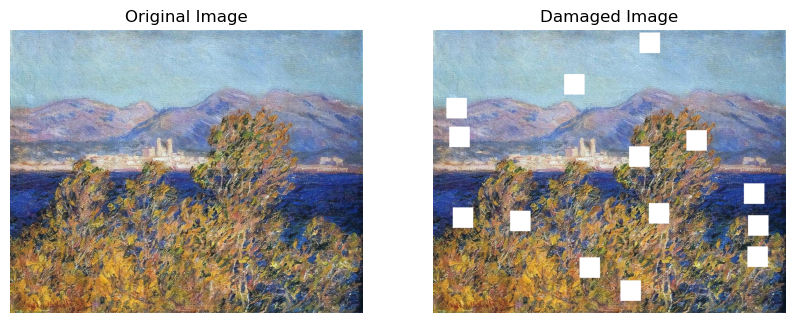

In [41]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the function
def damage_single_image(csv_file, root_dir, transform=None, mask_transform=None, index=0):
    """
    Selects an image from a CSV file and applies a masking transformation to damage it.
    
    Args:
        csv_file (str): Path to the CSV file with image paths.
        root_dir (str): Directory containing the images.
        transform (callable, optional): Transform to apply to the original image.
        mask_transform (callable, optional): Transform to apply the damage mask.
        index (int): Index of the image in the CSV file to damage.
    
    Returns:
        original_image (PIL.Image): The original image.
        damaged_image (PIL.Image): The damaged image.
    """
    # Load the CSV file and select the image
    df = pd.read_csv(csv_file)
    img_path = os.path.join(root_dir, df.iloc[index, 0])
    image = Image.open(img_path).convert('RGB')
    
    # Apply transformations
    original_image = transform(image) if transform else image
    damaged_image = None
    
    if mask_transform:
        # Apply the masking transform
        damaged_image = mask_transform(image.copy())
        
        # Separate the RGB channels (first 3) from the damage mask (alpha channel)
        damaged_array = np.array(damaged_image)
        rgb_image = Image.fromarray(damaged_array[:, :, :3])  # RGB channels
        damage_mask = Image.fromarray(damaged_array[:, :, 3])  # Alpha channel
        
        # Optionally convert RGB and mask to tensor for further processing
        if transform:
            rgb_image = transform(rgb_image)
            damage_mask = transform(damage_mask)
        else:
            rgb_image = transforms.ToTensor()(rgb_image)
            damage_mask = transforms.ToTensor()(damage_mask)
        
        # Concatenate the damage mask as an additional channel
        damaged_image = torch.cat((rgb_image, damage_mask), dim=0)
    
    return original_image, damaged_image

# Example usage
csv_file = 'validate_csv_test.csv'
root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
transform = transforms.ToTensor()
random_mask = RandomMask(max_size_fraction=1/16, max_vertices=8, mask_choice=None)

# Get the damaged image
original, damaged = damage_single_image(csv_file, root_dir, transform=transform, mask_transform=random_mask, index=0)

# Plot the original and damaged images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Convert tensors to numpy for plotting
if isinstance(original, torch.Tensor):
    original = original.permute(1, 2, 0).numpy()
if isinstance(damaged, torch.Tensor):
    damaged_rgb = damaged[:3].permute(1, 2, 0).numpy()  # Extract RGB channels
else:
    damaged_rgb = damaged[:, :, :3]

axes[0].imshow(original)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(damaged_rgb)
axes[1].set_title("Damaged Image")
axes[1].axis("off")

plt.show()


In [15]:
#14.12

# Feature extractor

In [ ]:
#If you want a different size (e.g., 128),
#you need to add a layer after the feature extractor to reduce
#dimensions or switch to a model with a smaller latent size.

"""
class CustomFeatureExtractor(nn.Module):
    def __init__(self, output_dim=128):
        super(CustomFeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Keep convolutional layers
        self.fc = nn.Linear(512, output_dim)  # Add a linear layer for custom latent space size

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Project to new latent space
        return x

# Instantiate with custom latent size
custom_model = CustomFeatureExtractor(output_dim=128)
"""

In [17]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load Pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove the fully connected (FC) layers to get raw features
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval()  # Set to evaluation mode


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label  


dataset = WikiArtDataset(csv_file="validated_csv.csv", root_dir=r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Extract Features
latent_vectors = []
with torch.no_grad():  # Disable gradient computation for faster processing
    for images, _ in tqdm(dataloader, desc="Extracting Features"):
        images = images.to(device)
        features = feature_extractor(images)  # Pass images through feature extractor
        features = features.view(features.size(0), -1)  # Flatten the features
        latent_vectors.append(features.cpu())  # Move to CPU and store

# Combine all features into a single tensor
latent_vectors = torch.cat(latent_vectors, dim=0)

# Save Latent Vectors
torch.save(latent_vectors, "latent_vectors.pt")


Extracting Features: 100%|██████████| 5043/5043 [52:42<00:00,  1.59it/s]


In [29]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# Load latent vectors
latent_vectors = torch.load("latent_vectors.pt")

# Convert latent vectors to NumPy for use in scikit-learn
latent_vectors = latent_vectors.numpy()

# Initialize PCA
pca = PCA()

# Fit PCA on latent vectors
pca.fit(latent_vectors)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components required to retain at least 90% variance
num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {num_components_90}")

# Reduce to 4 principal components
pca_4_components = PCA(n_components=4)
reduced_latent_vectors = pca_4_components.fit_transform(latent_vectors)

# Save the reduced latent vectors
np.save("reduced_latent_vectors.npy", reduced_latent_vectors)

# Save PCA model for later use if needed
import joblib
joblib.dump(pca_4_components, "pca_4_components.pkl")

C:\Users\Adas\AppData\Local\Temp\ipykernel_19016\4119967672.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors = torch.load("latent_vectors.pt")


Number of components to retain 90% variance: 183


['pca_4_components.pkl']

In [20]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import os

# Load reduced latent vectors
reduced_latent_vectors = np.load("reduced_latent_vectors.npy")

# Perform initial K-Means clustering
k = 15  # Replace with your desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(reduced_latent_vectors)

# Load the original CSV file to get the image paths
original_csv = "validated_csv.csv"
df = pd.read_csv(original_csv)

# Add cluster assignments to the DataFrame
df["cluster"] = clusters

# Count the number of images in each cluster
cluster_counts = df["cluster"].value_counts().to_dict()

# Check for clusters with fewer than 1500 images
cluster_centers = kmeans.cluster_centers_
reassignments = {}

while True:
    small_clusters = {cluster: count for cluster, count in cluster_counts.items() if count < 1500}
    if not small_clusters:
        break

    for small_cluster in small_clusters:
        # Calculate distances from the small cluster's center to other cluster centers
        distances = cdist([cluster_centers[small_cluster]], cluster_centers, metric='euclidean')[0]
        distances[small_cluster] = np.inf  # Ignore the small cluster itself

        # Find the nearest cluster
        nearest_cluster = np.argmin(distances)
        
        # Combine clusters if the total size is >= 1500
        combined_size = cluster_counts[small_cluster] + cluster_counts.get(nearest_cluster, 0)
        if combined_size >= 1500:
            print(f"Cluster {small_cluster} has too few images ({cluster_counts[small_cluster]}) and is added to cluster {nearest_cluster}")
            reassignments[small_cluster] = nearest_cluster
            cluster_counts[nearest_cluster] = combined_size
            del cluster_counts[small_cluster]

    # Update the DataFrame with reassigned clusters
    for small_cluster, nearest_cluster in reassignments.items():
        df.loc[df["cluster"] == small_cluster, "cluster"] = nearest_cluster

    # Update cluster counts and reassignments for the next iteration
    cluster_counts = df["cluster"].value_counts().to_dict()
    reassignments = {}

# Print final cluster information
real_clusters = len(cluster_counts)
print(f"Number of real clusters formed: {real_clusters}")

# Update cluster labels to reflect contiguous numbering
unique_clusters = sorted(cluster_counts.keys())
cluster_mapping = {old: new for new, old in enumerate(unique_clusters)}
df["cluster"] = df["cluster"].map(cluster_mapping)

# Save cluster information to separate CSVs based on real clusters
output_dir = "clusters_csv"
os.makedirs(output_dir, exist_ok=True)

for new_cluster_num in range(real_clusters):
    cluster_df = df[df["cluster"] == new_cluster_num]
    cluster_csv_path = os.path.join(output_dir, f"validated_csv_cluster_{new_cluster_num}.csv")
    cluster_df.to_csv(cluster_csv_path, index=False)

print(f"Cluster CSV files saved in directory: {output_dir}")


C:\Users\Adas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of real clusters formed: 15
Cluster CSV files saved in directory: clusters_csv


C:\Users\Adas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


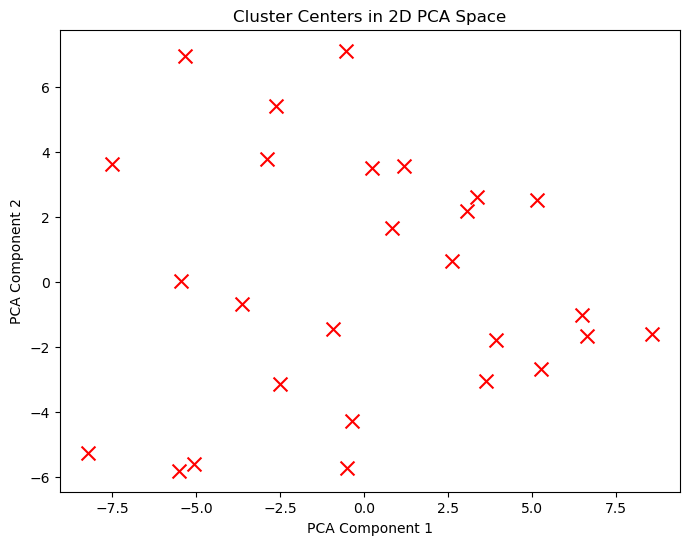

Cluster Centers (in latent space):
 [[-2.1732414   4.6020455   2.1348658  -4.214345  ]
 [ 6.152351   -2.283892    4.8545074   2.830593  ]
 [-5.208384    0.95446414 -0.49325615 -1.6153184 ]
 [ 6.6617665  -2.081651   -4.67378     0.3084861 ]
 [-6.6810727   4.441688   -4.227004    2.203752  ]
 [ 3.2320714  -3.1491327   2.8492155  -1.8411529 ]
 [-2.9506729  -2.3475509   4.010999   -0.9359839 ]
 [-4.153492    7.716346   -0.80864125 -0.04425373]
 [ 1.9405571   3.0821557  -4.6410475   3.1164343 ]
 [-8.596788   -4.1559343  -3.2612836   0.08958406]
 [-0.867631   -0.89783156  1.1319096  -4.945569  ]
 [ 0.47735944  7.5038285   2.9671342  -1.2018783 ]
 [ 4.0004916  -2.1535475  -1.9666333  -3.1625059 ]
 [ 0.9700454   3.5373406  -1.3075769  -1.0843706 ]
 [ 5.6561456   1.855709   -1.2897002  -0.04815134]
 [-3.7610633  -0.22435151  0.31181     4.650434  ]
 [ 3.120759    0.03063284 -6.0878816   0.07938714]
 [ 3.818711    2.5746036   2.7654788  -3.5170374 ]
 [-1.8965156   5.7718554   0.98218083  3.30952

In [40]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  

# Load latent vectors
#latent_vectors = torch.load("latent_vectors.pt")
latent_vectors = reduced_latent_vectors

# Convert latent vectors to NumPy for use in scikit-learn
#latent_vectors = latent_vectors.numpy()

# Number of clusters
num_clusters = 27
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(latent_vectors)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Use PCA to reduce the cluster centers to 2D for visualization
pca = PCA(n_components=2)
reduced_centers = pca.fit_transform(cluster_centers)

# Plot only the cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', marker='x', s=100)  # Plot cluster centers
plt.title("Cluster Centers in 2D PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

print("Cluster Centers (in latent space):\n", cluster_centers)


C:\Users\Adas\AppData\Local\Temp\ipykernel_38604\1709641499.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors = torch.load("latent_vectors.pt").numpy()
C:\U

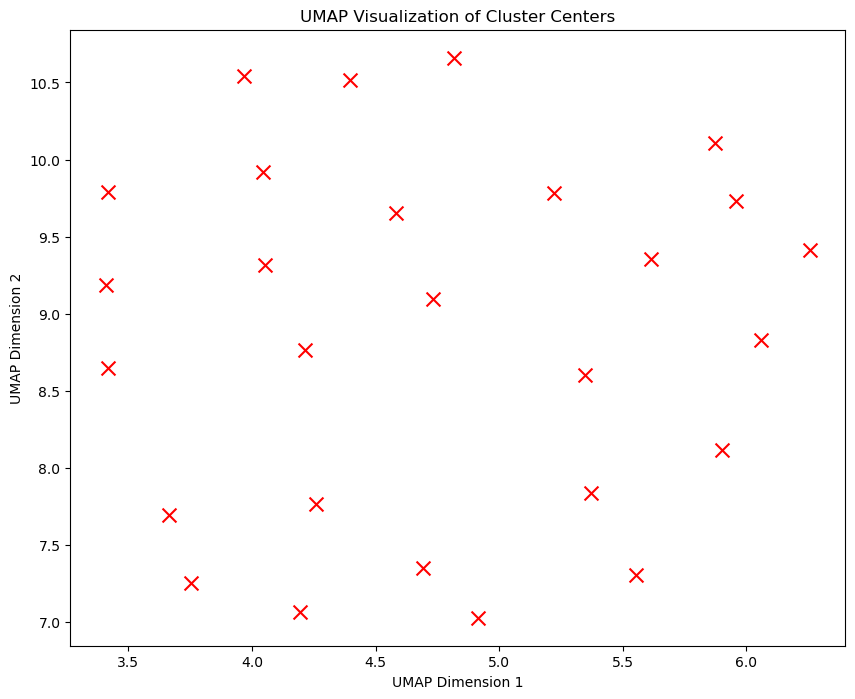

Cluster Centers (in latent space):
 [[0.738116   1.2398616  0.598338   ... 1.599007   0.63685536 1.2604607 ]
 [0.7395626  0.9047198  0.5746096  ... 1.353487   0.3533415  1.7868474 ]
 [0.7454919  0.9251107  0.7916776  ... 0.7411935  0.22274852 1.1900966 ]
 ...
 [1.3102646  0.48965392 0.977013   ... 1.3857961  0.37567186 0.4724539 ]
 [0.46024394 0.889934   0.63007295 ... 2.259272   0.60911745 1.6113498 ]
 [0.71412176 0.50054026 0.55770105 ... 1.4969263  0.42577818 1.1018921 ]]


In [51]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch

# Load Latent Vectors
latent_vectors = torch.load("latent_vectors.pt").numpy()

# Apply K-Means Clustering
num_clusters = 27  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(latent_vectors)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Apply UMAP for Dimensionality Reduction on Cluster Centers
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
reduced_centers = umap_reducer.fit_transform(cluster_centers)

# Visualize Cluster Centers in 2D
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_centers[:, 0], 
    reduced_centers[:, 1], 
    c='red', 
    marker='x', 
    s=100  # Size of the markers
)
plt.title("UMAP Visualization of Cluster Centers")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

print("Cluster Centers (in latent space):\n", cluster_centers)


In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Reload Pretrained ResNet18 as Feature Extractor
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove the fully connected (FC) layers to get raw features
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval()  # Set to evaluation mode

# Move the feature extractor to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# Define the same transform pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Function to process the image, extract features, and assign to cluster
def assign_image_to_cluster(image_path, feature_extractor, kmeans, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Extract features
    with torch.no_grad():
        latent_features = feature_extractor(image)
        latent_features = latent_features.view(latent_features.size(0), -1)  # Flatten features
    
    # Convert to NumPy for clustering
    latent_features_np = latent_features.cpu().numpy()

    # Assign the image to a cluster
    cluster = kmeans.predict(latent_features_np)[0]
    
    return latent_features_np, cluster

# Load the trained KMeans model
from sklearn.cluster import KMeans
latent_vectors = torch.load("latent_vectors.pt").numpy()  # Load latent vectors and convert to NumPy
num_clusters = 5  # Number of clusters used previously
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(latent_vectors)  # Reinitialize KMeans with the same latent vectors

# Path to the image you want to analyze
image_path = r"anc.png"

# Assign the image to a cluster
latent_space, assigned_cluster = assign_image_to_cluster(
    image_path=image_path,
    feature_extractor=feature_extractor,
    kmeans=kmeans,
    transform=transform,
    device=device
)

# Print the results
print("Latent space representation of the image:\n", latent_space)
print("Assigned Cluster:", assigned_cluster)


C:\Users\Adas\AppData\Local\Temp\ipykernel_39988\1587207262.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors = torch.load("latent_vectors.pt").numpy()  # 

Latent space representation of the image:
 [[1.0438241  0.87063366 0.49492294 1.9625124  0.5299511  1.1870482
  1.8366704  0.11597885 0.46100706 1.9817425  0.79823613 0.3617939
  0.04620323 0.7049606  0.01862888 0.9302122  0.79147    0.25553995
  0.6456371  0.64184636 0.5589226  0.2384925  2.678527   2.5171697
  0.79340523 0.4950418  0.01421207 0.25988543 0.17505352 0.5978315
  0.79423416 0.19860062 0.12696159 0.8637145  0.8827034  1.1108664
  0.4097818  0.13541582 0.43130213 0.06737769 0.3249725  0.20671272
  0.40709448 0.15905446 0.48712248 0.52001333 0.43863246 0.65153265
  0.7887108  0.26983982 1.9143058  1.1712809  1.833783   1.0268297
  1.1414223  1.2289027  1.8013153  0.07673245 0.73985976 0.8807719
  0.3792957  0.24238127 1.0759426  0.6136652  0.45722443 2.6620972
  2.3581016  0.28493312 0.49741966 0.01633959 0.50620633 0.13033077
  0.5484126  0.7437591  0.25635895 2.0217242  0.09365091 1.8417403
  0.04543991 0.7885157  0.07961874 2.2849865  1.1483533  0.48336026
  0.34532678 0

# aplikacja do ekstraktora

In [5]:
import tkinter as tk
from tkinter import filedialog, messagebox
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, ImageTk
from sklearn.cluster import KMeans
import numpy as np


# Reload Pretrained ResNet18 as Feature Extractor
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval()  # Set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# Define the transform pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the trained latent vectors and KMeans model
latent_vectors = torch.load("latent_vectors.pt").numpy()
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(latent_vectors)  # Refit KMeans


# Function to process the image, extract features, and assign to cluster
def assign_image_to_cluster(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        preprocessed_image = transform(image).unsqueeze(0).to(device)

        # Extract features
        with torch.no_grad():
            latent_features = feature_extractor(preprocessed_image)
            latent_features = latent_features.view(latent_features.size(0), -1).cpu().numpy()

        # Assign the image to a cluster
        cluster = kmeans.predict(latent_features)[0]
        return latent_features, cluster, image
    except Exception as e:
        messagebox.showerror("Error", f"Failed to process the image: {str(e)}")
        return None, None, None


# GUI Application
class FeatureExtractorApp:
    def __init__(self, master):
        self.master = master
        master.title("Feature Extractor and Clustering")
        master.geometry("600x400")

        # UI Components
        self.label = tk.Label(master, text="Select an image to extract features and assign to a cluster.")
        self.label.pack(pady=10)

        self.image_label = tk.Label(master)
        self.image_label.pack()

        self.results_label = tk.Label(master, text="", font=("Arial", 12))
        self.results_label.pack(pady=10)

        self.select_button = tk.Button(master, text="Choose File", command=self.choose_file)
        self.select_button.pack(pady=5)

        self.process_button = tk.Button(master, text="Extract Features", command=self.process_image, state=tk.DISABLED)
        self.process_button.pack(pady=5)

        self.image_path = None

    def choose_file(self):
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg *.jpeg *.png")])
        if self.image_path:
            # Display selected image
            img = Image.open(self.image_path)
            img.thumbnail((200, 200))
            img_tk = ImageTk.PhotoImage(img)
            self.image_label.config(image=img_tk)
            self.image_label.image = img_tk  # Keep reference to avoid garbage collection

            # Enable processing button
            self.process_button.config(state=tk.NORMAL)

    def process_image(self):
        if not self.image_path:
            messagebox.showwarning("Warning", "Please choose an image file first.")
            return

        latent_space, assigned_cluster, img = assign_image_to_cluster(self.image_path)
        if latent_space is not None:
            self.results_label.config(
                text=f"Assigned Cluster: {assigned_cluster}\nLatent Space (first 5 dims): {latent_space[0, :5]}"
            )


# Run the GUI
if __name__ == "__main__":
    root = tk.Tk()
    app = FeatureExtractorApp(root)
    root.mainloop()


C:\Users\Adas\AppData\Local\Temp\ipykernel_39988\665451762.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors = torch.load("latent_vectors.pt").numpy()
C:\U

# teraz sprobuje autoenkoder

In [13]:
import torch
import torch.nn as nn

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with dilated convolutions
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU()
        )

        # Decoder with skip connections
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU()
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU()
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU()
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1


C:\Users\Adas\AppData\Local\Temp\ipykernel_29668\3228227775.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)
C:\Users\Adas\AppData\Lo

Found checkpoint. Last completed epoch: 45
Resuming training from epoch 45...
Epoch [46/47], Training Loss: 0.0013
Epoch [46/47], Test Loss: 0.0014
Epoch [47/47], Training Loss: 0.0013
Epoch [47/47], Test Loss: 0.0013
Model saved at epoch 47.


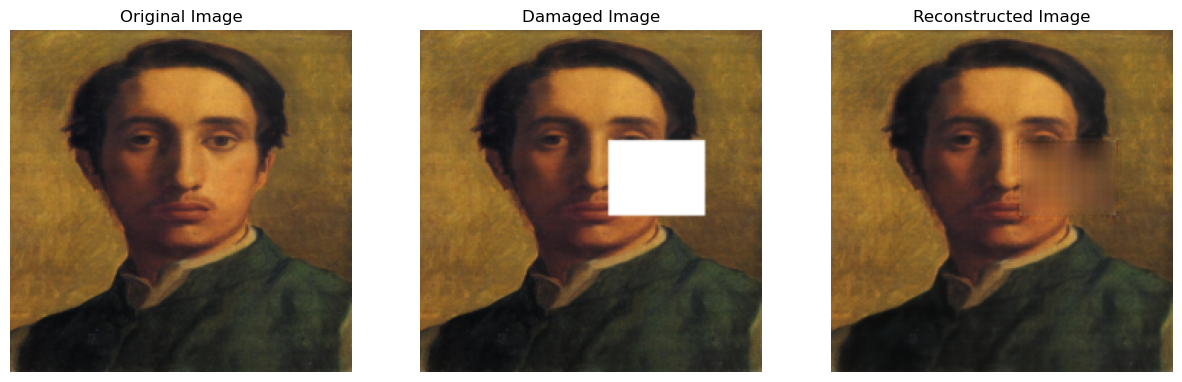

In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

# RandomMask class to damage images
class RandomMask:
    def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
        self.mask_max_size = max_size_fraction
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice

    def __call__(self, image):
        if self.mask_choice is None:
            self.mask_choice = random.choice(["square", "random_square", "random_polygon"])
        
        im_width, im_height = image.size
        max_mask_size = int((im_width * im_height) * self.mask_max_size)
        square_mask_size = int(max_mask_size ** 0.5)

        if self.mask_choice == "square":
            x = random.randint(0, im_width - square_mask_size)
            y = random.randint(0, im_height - square_mask_size)
            image.paste((255, 255, 255), (x, y, x + square_mask_size, y + square_mask_size))
        
        elif self.mask_choice == "random_square":
            small_mask_size = 100
            iterations = max_mask_size // (small_mask_size * small_mask_size)
            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)
                image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
        
        elif self.mask_choice == "random_polygon":
            draw = ImageDraw.Draw(image)
            num_vertices = random.randint(3, self.max_vertices)
            vertices = [(random.randint(0, im_width), random.randint(0, im_height)) for _ in range(num_vertices)]
            draw.polygon(vertices, fill=(255, 255, 255))
        
        return image

# Dataset class with image masking
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        original_image = self.transform(image) if self.transform else image
        damaged_image = None

        if self.mask_transform:
            # Apply masking to the image to create a damaged version
            damaged_image = self.mask_transform(image.copy())
            damaged_image = self.transform(damaged_image) if self.transform else damaged_image

        return original_image, damaged_image

# Train function with save and resume functionality
def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0003)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        # Training loop
        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            _, reconstructed_images = autoencoder(damaged_images)
            #reconstructed_images = autoencoder(damaged_images)


            # Compute the loss
            loss = criterion(reconstructed_images, original_images)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}")

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                _, reconstructed_images = autoencoder(damaged_images)
                #reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.4f}")

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")

# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()

# Main function
if __name__ == "__main__":
    # Path to your CSV file and image directory
    csv_file = "validated_csv_easy.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    save_path = "InpaintingAdvancedAutoencoder.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    mask_transform = RandomMask(max_size_fraction=1/16, max_vertices=8, mask_choice="square")

    # Create the dataset
    dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_transform=mask_transform)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)  # You can use any fixed integer seed
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Initialize the autoencoder
    autoencoder = InpaintingAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Start or resume training
    start_epoch = 0
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    # Train the autoencoder
    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=47, start_epoch=start_epoch)

    # Visualize some images
    original_image, damaged_image = next(iter(test_loader))  # Get one batch
    original_image = original_image[0:1]  # Select the first image
    damaged_image = damaged_image[0:1]  # Select the first damaged image
    _, reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    #reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    # Visualize the result
    visualize_images(original_image, damaged_image, reconstructed_image)


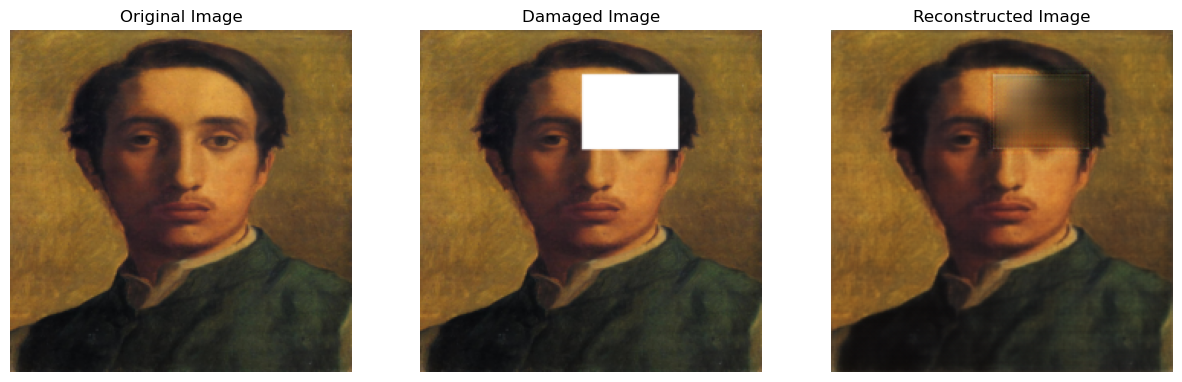

In [66]:
# Visualize a specific image from the dataset
def visualize_fixed_image(autoencoder, dataset, index=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder.eval()  # Set the autoencoder to evaluation mode

    # Get the fixed image (original and damaged) using the specified index
    original_image, damaged_image = dataset[index]

    # Add a batch dimension to the image tensors
    original_image = original_image.unsqueeze(0).to(device)
    damaged_image = damaged_image.unsqueeze(0).to(device)

    # Generate reconstructed image
    with torch.no_grad():
        _, reconstructed_image = autoencoder(damaged_image)

    # Visualize the result
    visualize_images(original_image, damaged_image, reconstructed_image)

# Main function continued
if __name__ == "__main__":
    # Ensure reproducibility by fixing the random seed
    random.seed(42)
    torch.manual_seed(42)
    #autoencoder = Autoencoder()
    # Visualize a fixed image (e.g., the first one in the test dataset)
    visualize_fixed_image(autoencoder, test_dataset, index=0)


In [1]:
# poprawki 10.01


In [108]:
# superres
import torch
import torch.nn as nn

class SuperResolutionAutoencoder(nn.Module):
    def __init__(self, upscale_factor=2):
        super(SuperResolutionAutoencoder, self).__init__()

        # Encoder: Decrease downsampling, keeping more spatial resolution
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck: Latent space, reduced downsampling
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),  # 1024x7x7
            nn.ReLU(),
        )

        # Decoder: Use Pixel Shuffle for upsampling
        self.decoder = nn.ModuleDict({
            "deconv5": nn.Sequential(
                nn.Conv2d(1024, 256 * (upscale_factor ** 2), kernel_size=3, padding=1),  # 256x7x7
                nn.PixelShuffle(upscale_factor),  # Upscale by factor of 2 or 3
                nn.ReLU()
            ),
            "deconv4": nn.Sequential(
                nn.Conv2d(256, 128 * (upscale_factor ** 2), kernel_size=3, padding=1),  # 128x14x14
                nn.PixelShuffle(upscale_factor),  # Upscale by factor of 2 or 3
                nn.ReLU()
            ),
            "deconv3": nn.Sequential(
                nn.Conv2d(128, 64 * (upscale_factor ** 2), kernel_size=3, padding=1),  # 64x28x28
                nn.PixelShuffle(upscale_factor),  # Upscale by factor of 2 or 3
                nn.ReLU()
            ),
            "deconv2": nn.Sequential(
                nn.Conv2d(64, 32 * (upscale_factor ** 2), kernel_size=3, padding=1),  # 32x56x56
                nn.PixelShuffle(upscale_factor),  # Upscale by factor of 2 or 3
                nn.ReLU()
            ),
            "deconv1": nn.Sequential(
                nn.Conv2d(32, 3 * (upscale_factor ** 2), kernel_size=3, padding=1),  # 3x112x112
                nn.PixelShuffle(upscale_factor),  # Upscale by factor of 2 or 3
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        enc5 = self.encoder[8:10](enc4)  # 512x7x7
        bottleneck = self.bottleneck(enc5)  # 1024x7x7

        # Decode with Pixel Shuffle
        dec5 = self.decoder["deconv5"](bottleneck)  # 256x14x14
        dec4 = self.decoder["deconv4"](dec5)  # 128x28x28
        dec3 = self.decoder["deconv3"](dec4)  # 64x56x56
        dec2 = self.decoder["deconv2"](dec3)  # 32x112x112
        dec1 = self.decoder["deconv1"](dec2)  # 3x224x224

        return dec1


In [115]:

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with dilated convolutions
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU()
        )

        # Decoder with skip connections
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU()
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU()
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU()
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1